In [3]:
import os
import pickle
from scipy.misc import imread
from os.path import join
import numpy as np
import itertools
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob

## Create files with number of lesions per image for train, valid, test

In [14]:
def checkIntersection(s1, s2):
    segment_endpoints = []
    left = max(min(s1[0][0], s1[1][0]), min(s2[0][0], s2[1][0]))
    right = min(max(s1[0][0], s1[1][0]), min(s2[0][0], s2[1][0]))
    top = max(min(s1[0][1], s1[1][1]), min(s2[0][1], s2[1][1]))
    bottom = min(max(s1[0][1], s1[1][1]), min(s2[0][1], s2[1][1]))

    # 'NO INTERSECTION'
    if top > bottom or left > right:
        segment_endpoints = []
        return False

    # 'POINT INTERSECTION'
    elif top == bottom and left == right:
        segment_endpoints.append(left)
        segment_endpoints.append(top)
        return True
    
    # 'SEGMENT INTERSECTION'
    else:
        segment_endpoints.append(left)
        segment_endpoints.append(bottom)
        segment_endpoints.append(right)
        segment_endpoints.append(top)         
        return True

In [15]:
def to_int(s):
    try:
        return int(s)
    except ValueError:
        return int(float(s))

In [23]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import pickle
import itertools


ftype = 'valid'
xml_directory = '/home/anastasia/cropDL/data/heatmaps/annotations/tyr_lesion_'+ftype
roots = []
xml_files = os.listdir(xml_directory)


for file_name in xml_files:
    xml_tree = ET.parse(os.path.join(xml_directory,file_name))
    root = xml_tree.getroot()
    roots.append(root)

d={}
nmb_intersections = 0
nmb_lines = 0
files_with_intersections = []

for root in roots:    
    name = root.get('name')
    
    segments = []
    count = 0
    for line in root:
        if line.tag == 'line':
            count += 1
            nmb_lines+=1
            
            # extract segments
            segment = []
            for i, node in enumerate(line.getchildren()):
                segment.append((to_int(node.attrib['x']), to_int(node.attrib['y'])))
            segments.append(segment)   
    
    # check intersections and correct count        
    for i,(seg1, seg2) in enumerate(itertools.combinations(segments, 2)):
        if checkIntersection(seg1, seg2):
            nmb_intersections+=1
            count-=1
            files_with_intersections.append(name)
    d[name] = count
print nmb_intersections*1./nmb_lines

with open('num_lesions_'+ftype+'.pickle', 'wb') as fout:
    pickle.dump(d, fout)
    
with open('files_with_intersections'+ftype+'.pickle', 'wb') as fout:
    pickle.dump(set(files_with_intersections), fout)

0.134050880626


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


### Merge and save the results train, valid

In [17]:
d = {}

for ftype in ['train', 'valid']:
    with open('num_lesions_'+ftype+'.pickle', 'r') as fin:
        d.update(pickle.load(fin))

In [20]:
with open('num_lesions_all.pickle', 'wb') as fout:
    pickle.dump(d, fout)

## Create X Y train valid


In [24]:
DATA_PATH = '/home/anastasia/cropDL/data/heatmaps'
num_lesion_file = 'pickles/num_lesions_all.pickle'

valid_lesion_dirs = ['tcrop13_lesion', 'tcrop16_lesion937', 'tcrop22-3_lesion940',]

with open(join(DATA_PATH, num_lesion_file), 'rb') as fin:
    number_of_lesions_per_image = pickle.load(fin)

In [25]:
def countFiles(folder, exts):
    nmb = 0
    for ext in exts:
        nmb+=len(glob.glob1(folder,ext))
    return nmb

In [26]:
image_size = 193*126
img_h = 126
img_w = 193
img_h_small = 108
img_w_small = 166

# number of files to work with
num_no_lesion_pics = countFiles(join(DATA_PATH,'tcrop13_no_lesion'), ['*.JPG', '*.Jpeg'])
num_lesion_pics = countFiles(join(DATA_PATH,valid_lesion_dirs[0]), ['*.JPG', '*.Jpeg'])
num_valid_pics = num_lesion_pics



#### Create X-Y valid set:

In [27]:
nmb_dirs = len(valid_lesion_dirs)

X_valid = np.zeros((num_valid_pics, nmb_dirs, img_h, img_w))
Y_valid = np.zeros(num_valid_pics)

for i_pic, pic_name in enumerate(os.listdir(join(DATA_PATH, valid_lesion_dirs[0]))): 
    for i_dir, vl_dir in enumerate(valid_lesion_dirs):
        pic = imread(join(DATA_PATH, vl_dir, pic_name))
        if pic.shape == (img_h_small,img_w_small): 
            X_valid[i_pic, i_dir,:img_h_small, :img_w_small] = pic
        else:
            X_valid[i_pic, i_dir,:,:]= pic
    Y_valid[i_pic] = number_of_lesions_per_image[pic_name]
    
np.savez('../data/valid_set.npz', x=X_valid, y=Y_valid)

#### Create X-Y train set:

In [28]:
def rotate_images(X):
    X_rot = np.copy(X)            
    
    for i_pic in list(itertools.product(np.arange(X.shape[0]),np.arange(X.shape[1]))): 
        X_rot[i_pic]=np.rot90(X_rot[i_pic],2)
    return X_rot

def fliplr_images(X):
    X_fliplr = np.copy(X)            
    
    for i_pic in list(itertools.product(np.arange(X.shape[0]),np.arange(X.shape[1]))): 
        X_fliplr[i_pic]=np.fliplr(X_fliplr[i_pic])
    return X_fliplr

def flipud_images(X):
    X_flipud = np.copy(X)            
    
    for i_pic in list(itertools.product(np.arange(X.shape[0]),np.arange(X.shape[1]))): 
        X_flipud[i_pic]=np.flipud(X_flipud[i_pic])
    return X_flipud

In [29]:
train_lesion_dirs = ['tcrop13_lesion_train', 'tcrop22-3_lesion940_train', 'tcrop16_lesion937train']

num_lesion_pics_train = countFiles(join(DATA_PATH,train_lesion_dirs[0]), ['*.JPG', '*.Jpeg'])
nmb_dirs = len(train_lesion_dirs)

X_train = np.zeros((num_lesion_pics_train, nmb_dirs, img_h,img_w))
Y_train = np.zeros(num_lesion_pics_train)

for i_pic, pic_name in enumerate(np.sort(os.listdir(join(DATA_PATH, train_lesion_dirs[0])))):
    for j_dir, tl_dir in enumerate(train_lesion_dirs):
        pic = imread(join(DATA_PATH, tl_dir, pic_name))
        if pic.shape == (img_h_small, img_w_small): 
            X_train[i_pic, j_dir, :img_h_small, :img_w_small] = pic
        else:
            X_train[i_pic,j_dir,:,:] = pic
    Y_train[i_pic] = number_of_lesions_per_image[pic_name]

X_rot = rotate_images(X_train)
X_fliplr = fliplr_images(X_train)
X_flipud = flipud_images(X_train)
X_train = np.concatenate((X_train, X_rot, X_fliplr, X_flipud), axis=0)

Y_train = np.tile([int(y) for y in Y_train], 4) 

np.savez('../data/train_set.npz', x=X_train, y=Y_train)

### Intresting examples

#### Max number of lesions

DSC06704.JPG nmb of lesions:  44


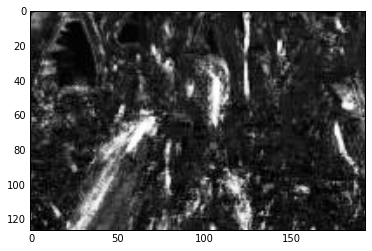

In [30]:
pic_most_lesioned = np.sort(os.listdir(join(DATA_PATH, train_lesion_dirs[0])))[np.argmax(Y_train)]
print pic_most_lesioned, "nmb of lesions: ", int(np.max(Y_train))

img = Image.open(join(DATA_PATH, train_lesion_dirs[0],pic_most_lesioned))
plt.imshow(img, cmap='Greys_r')

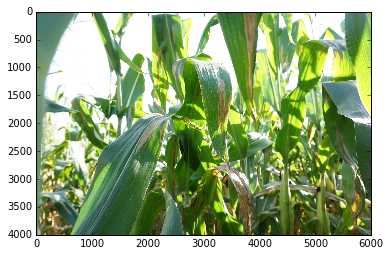

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

original_img = Image.open(join('/home/anastasia/cropDL/data/nlb_annotated_close/close_lesion/2015_09_21'\
                               ,pic_most_lesioned))
plt.imshow(original_img)

In [34]:
print Y_train.mean()
print Y_valid.mean()
print Y_train.

5.81084840056
5.95424836601
29.1297293219
